### Project Overview:
- For this project you will need to fetch Adj Close every company in the Russell 2000 for 2020 (Time Frame Jan 1 - current) 
- We would like to see the Dips and Gains/ Daily Returns of every stock under priced under 10 dollars in ascending order.
- Repeat the same process for every company in the entire index
- Using portfolio optimization techniques find 20 companies in a portfolio that would generate a "Good" return during the current Pandemic. 
- We want you to than go back 5 years and see how these companies performed pre-Covid. What is the max return we would have received during this 5 year period considering volatility.

### Project Approach
- Fetch all companies in Russell 2000
- Use pandas Datareader to get the Adj Close
- Calculate the Daily returns for each security
- Find the top 20 Gains and Dips for returns for the current day
- Put every security into a portfolio and optimize the portfolio with 5 years of data (2015-2019 end)
- Find the top companies the make up the index by weight and isolate them into a portfolio of their own
- Run a portfolio optimization on the portfolio using Markowitz Efficient Frontier and see what the ortfolio would have returned pre-Covid. 

### Acknowledgements
- Data was downloaded provided from Ben Reynolds at Secure Dividends
- https://www.suredividend.com/

### libraries


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from pandas_datareader import data as web

In [2]:
russ = pd.read_excel("resources/Russle_2000_2020.xlsx", index_col='Ticker')

### Data Overview 
- Data below provides all of the data tickers and companies in the Russell 2000

In [3]:
russ

,Name
Ticker,
AAN,"Aaron's, Inc."
AAOI,"Applied Optoelectronics, Inc."
AAON,"AAON, Inc."
AAT,"American Assets Trust, Inc."
AAWW,"Atlas Air Worldwide Holdings, Inc."
...,...
ZIXI,Zix Corp.
ZUMZ,"Zumiez, Inc."
ZUO,"Zuora, Inc."


In [4]:
russ.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1999 entries, AAN to ZYXI
Data columns (total 1 columns):
Name    1999 non-null object
dtypes: object(1)
memory usage: 31.2+ KB


### Adj Closes
- Will import data already fetched previously
- Will download the Adj Close for each security for 2020 beginning 2020-1-1 to current using pandas Datareader

In [5]:
tickers = list(russ.index)

In [6]:
len(tickers)

1999

In [7]:
data = pd.DataFrame()

In [17]:
failed = []
passed = []
for x in tickers:
    try:
        data[x] = web.DataReader(x, data_source= "yahoo", start = "2020-1-1")["Adj Close"]
        passed.append(x)
    except (IOError, KeyError):
        msg = 'Failed to read symbol: {0!r}, replacing with NaN.'
        failed.append(x)

### Passed Tickers
- There are 1941 tickers that passed in the Yahoo data reader library
- We will use these for our analysis

In [11]:
len(passed)

1137

### Saving Passed Tickers

In [9]:
#pd.DataFrame(passed, columns=["passed"]).to_csv("resources/current/passed_tickers.csv")

In [8]:
penny = pd.read_csv("resources/current/penny_tickers.csv", index_col= "Unnamed: 0")

In [9]:
penny_tickers = list(penny["under 10"])

In [10]:
penny_data = pd.DataFrame()

In [11]:
failed = []
passed = []
for x in list(penny_tickers):
    try:
        penny_data[x] = web.DataReader(x, data_source= "yahoo", start = "2020-7-10")["Adj Close"]
        passed.append(x)
    except (IOError, KeyError):
        msg = 'Failed to read symbol: {0!r}, replacing with NaN.'
        failed.append(x)

In [12]:
#pd.DataFrame(penny_tickers, columns=["under 10"]).to_csv("resources/current/penny_tickers.csv")

## Checking the Daily returns for  the Russell 2000
- Will check today's Date for the Dips and Spikes in the entire index
- Will find the to 20 companies that had a negative return for todays date

In [13]:
penny_data.pct_change().iloc[-1:].transpose().sort_values("2020-07-17", ascending = False)

Date,2020-07-17
CKPT,0.401138
OCN,0.307692
AHT,0.284722
TTI,0.267937
DVAX,0.197429
...,...
CVGI,-0.070312
BGG,-0.079146
SIEN,-0.093617
JILL,-0.180345


## Dips 

In [25]:
top_20_dips = data.pct_change()[-1:].transpose()

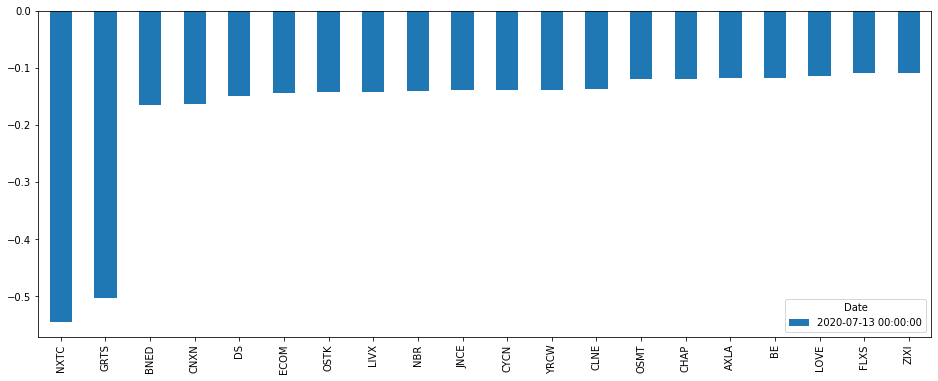

In [76]:
top_20_dips.plot(kind = "bar", figsize = (16,6))

## Spikes

In [74]:
top_20_Spikes = data.pct_change()[-1:].transpose().sort_values("2020-07-13", ascending = False).dropna().head(20)

In [77]:
top_20_Spikes

Date,2020-07-13
ECOR,1.094118
RIGL,0.213483
BHR,0.107438
INSE,0.106707
NVAX,0.105553
CHS,0.100775
INO,0.095808
MESA,0.093458
PTE,0.089431
BRT,0.078035


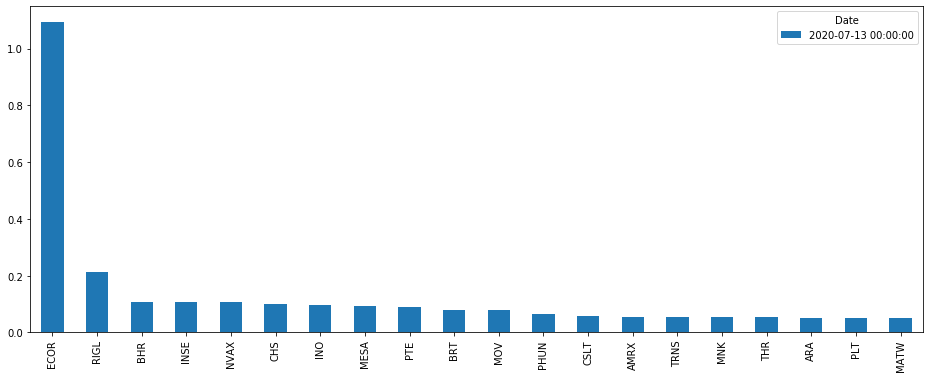

In [80]:
top_20_Spikes.plot(kind = "bar", figsize = (16,6))

### Optimizing the Russell 2000 as a portfolio
- Will put every company in a portfolio and see which companies would have held the mose weight during the 2020 covid 19 crisis thu far. 
- Will use markowitz Portfolio theor to optimize the Russell
- Will use 2000 randomly allocated portfolios to get the efficient frontier using a combination of volatility and expected returns
- We will drop companies with missing data for the time being

In [102]:
russell_Returns = data.dropna(axis=1).pct_change()

In [103]:
tic = list(russell_Returns.columns)

In [104]:
n_portfolios = 2000
all_weights = np.zeros((n_portfolios, len(tic)))
all_returns = np.zeros(n_portfolios)
all_vol = np.zeros(n_portfolios)
all_sharp = np.zeros(n_portfolios)

for ind in range(n_portfolios):
    weights = np.array(np.random.random(len(tic)))
    weights = weights/weights.sum()   
    all_weights[ind,:] = weights
    
    all_returns[ind] = np.sum(russell_Returns.mean() * weights) * 252
    all_vol[ind] = np.dot(weights.T, np.dot(russell_Returns.cov() * 252, weights))
    all_sharp[ind] = all_returns[ind]/ all_vol[ind]

### Plotting the Frontier
- The frontier will provide a good insight on the max return hightest sharp and the lowest volatility of the portfolios

In [106]:
hightest_return = all_returns.argmax()

In [107]:
lowest_vol = all_vol.argmin()

In [108]:
higherst_sharp = all_sharp.argmax()

In [127]:
all_returns.max()

-0.01172690739902448

#### Frontier 
- We see two things in the froniter
- The portfolio with the highest sharp is provides the same return as the portfolio with the highrest return 
- Appears the highest return for a portfolio containing every company in the Russell is in the negative
- This is not realistic and the main purpose was to find the top 20 weighted companies in 2020
- We will fetch these below

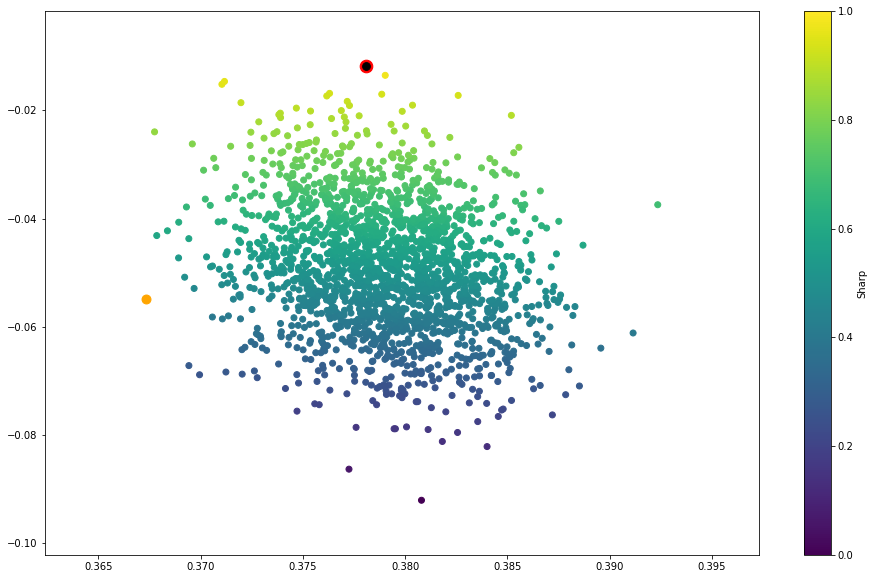

In [126]:
plt.figure(figsize = (16,10))
plt.scatter(all_vol, all_returns, c=all_sharp)
plt.scatter(all_vol[hightest_return], all_returns[hightest_return], c="r", s = 160)
plt.scatter(all_vol[lowest_vol], all_returns[lowest_vol], c="orange", s = 80)
plt.scatter(all_vol[higherst_sharp], all_returns[higherst_sharp], c="black", s = 60)

plt.colorbar(label = "Sharp")

## Bringing the data together 
- Creating a data frame for the weights returns and sharp

In [145]:
frontier_df = pd.DataFrame(all_returns, columns=["returns"])

In [146]:
frontier_df = pd.concat([frontier_df, pd.DataFrame(all_vol, columns=["vol"])], axis=1)

In [149]:
shp_df = pd.DataFrame(all_sharp, columns=["shp"])

In [150]:
frontier_df = pd.concat([frontier_df, shp_df], axis=1)

In [152]:
weights_df = pd.DataFrame(all_weights, columns=tic)

In [154]:
frontier_df = pd.concat([frontier_df, weights_df], axis=1)

In [156]:
## frontier_df.to_csv("resources/current/frontier_entier_russell.csv")

### Lets find the portfolio with the highest returns
- Will take the top 20 compaines by weight in this portfolio and create a new portfolio with just these 20 companies

In [168]:
highest_ret_port = pd.DataFrame(frontier_df.sort_values("returns", ascending = False).loc[1869])

In [171]:
highest_ret_port.drop(["returns", "vol", "shp"], inplace=True)

## Below are the top 20 weighted companies 
- will create a portfolio for just these companies and see what our returns would have been for 2020

In [179]:
top_20_weighted = highest_ret_port.sort_values(1869, ascending = False).head(20)

In [182]:
top20_tickers = list(top_20_weighted.index)

In [184]:
top_20_df = pd.DataFrame()

In [185]:
for y in top20_tickers:
    top_20_df[y] = web.DataReader(y, data_source="yahoo", start = "2020-1-1")["Adj Close"]

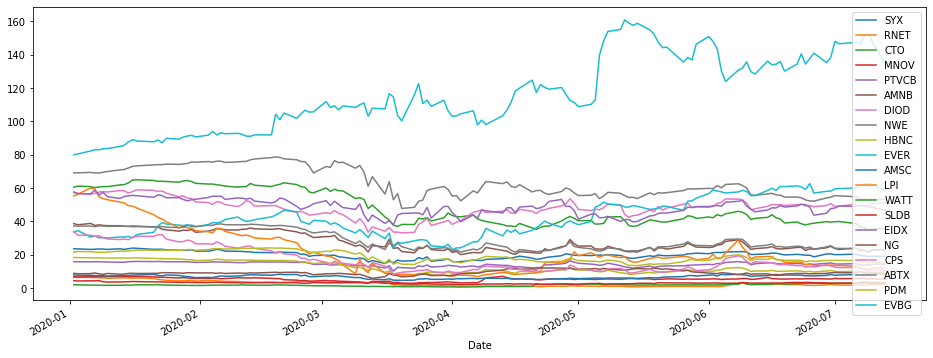

In [188]:
top_20_df.plot(figsize = (16,6))

In [189]:
top_20_df

,SYX,RNET,CTO,MNOV,PTVCB,AMNB,DIOD,NWE,HBNC,EVER,AMSC,LPI,WATT,SLDB,EIDX,NG,CPS,ABTX,PDM,EVBG
Date,,,,,,,,,,,,,,,,,,,,
2020-01-02,23.590525,6.60,60.556934,6.68,15.847412,38.665291,57.299999,69.122437,18.332451,33.790001,7.89,55.200001,1.98,4.43,57.619999,8.84,33.880001,37.230312,21.578705,79.989998
2020-01-03,23.487511,6.45,61.150726,6.63,15.817844,37.958714,56.639999,69.122437,18.244640,34.439999,7.68,56.400002,1.92,4.25,56.660000,8.59,31.639999,37.150829,21.921225,80.419998
2020-01-06,23.187830,6.47,60.834038,6.80,15.729148,38.773235,56.320000,69.377502,18.205616,30.559999,7.68,60.000000,1.78,4.36,56.540001,8.67,31.719999,37.170700,21.803789,82.230003
2020-01-07,23.337669,6.29,60.240242,6.91,15.817844,37.566174,56.840000,69.024338,18.078781,31.219999,7.56,59.400002,1.78,4.32,58.689999,9.09,31.139999,36.813004,21.578705,82.989998
2020-01-08,23.440685,6.20,60.636105,6.87,15.788280,37.909649,57.549999,69.024338,18.195858,30.139999,7.41,54.799999,1.72,4.43,55.810001,8.50,31.360001,37.309799,21.519987,82.949997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-07,19.520000,1.75,36.759998,5.70,14.000000,22.450001,49.299999,53.299999,9.580000,61.619999,7.95,12.270000,3.42,2.99,49.740002,9.71,11.720000,23.170000,15.620000,146.389999
2020-07-08,19.320000,1.69,36.230000,5.78,13.710000,22.590000,49.310001,53.570000,9.460000,62.470001,8.26,11.810000,3.86,3.08,49.240002,9.16,11.170000,22.709999,15.430000,151.460007
2020-07-09,18.820000,1.71,35.000000,5.49,13.860000,21.510000,49.790001,52.419998,9.050000,62.790001,8.53,11.140000,3.36,2.96,48.820000,8.65,10.020000,21.740000,15.020000,151.970001


In [190]:
top_20_returns = top_20_df.pct_change()

### Volatility 
- This portfolio has a high vol minly occurring with 2 companies
- Lets calculate the volatility below 

In [198]:
np.sum(top_20_returns.mean() * 252)

0.17715309902614762

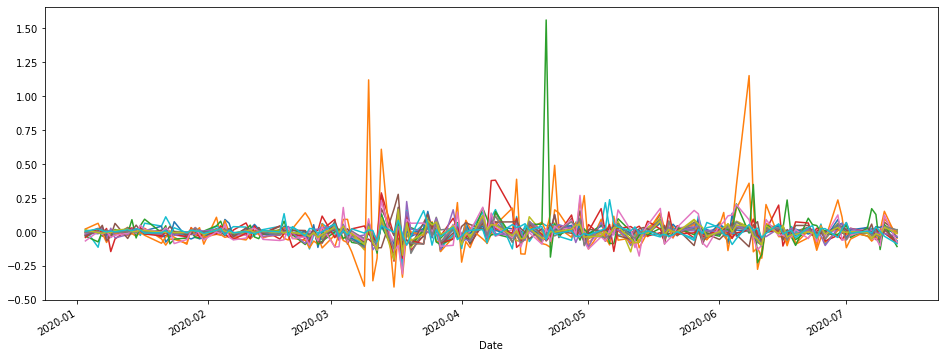

In [200]:
top_20_returns.plot(figsize = (16,6), legend = False)

In [201]:
n_portfolios = 2000
all_weights = np.zeros((n_portfolios, len(top_20_df.columns)))
all_returns = np.zeros(n_portfolios)
all_vol = np.zeros(n_portfolios)
all_sharp = np.zeros(n_portfolios)

for ind in range(n_portfolios):
    weights = np.array(np.random.random(len(top_20_df.columns)))
    weights = weights/weights.sum()   
    all_weights[ind,:] = weights
    
    all_returns[ind] = np.sum(top_20_returns.mean() * weights) * 252
    all_vol[ind] = np.dot(weights.T, np.dot(top_20_returns.cov() * 252, weights))
    all_sharp[ind] = all_returns[ind]/ all_vol[ind]

In [202]:
max_return = all_returns.argmax()

In [203]:
max_Sharp = all_sharp.argmax()

In [204]:
lowest_vol = all_vol.argmin()

### Summary
- This portfolio would have yielded you 38% return year to date 
- Not bad even during Covid 

In [208]:
all_returns.max()

0.38919563229425524

In [209]:
all_sharp.max()

1.0604261126275902

In [210]:
all_vol.min()

0.2865265340650774

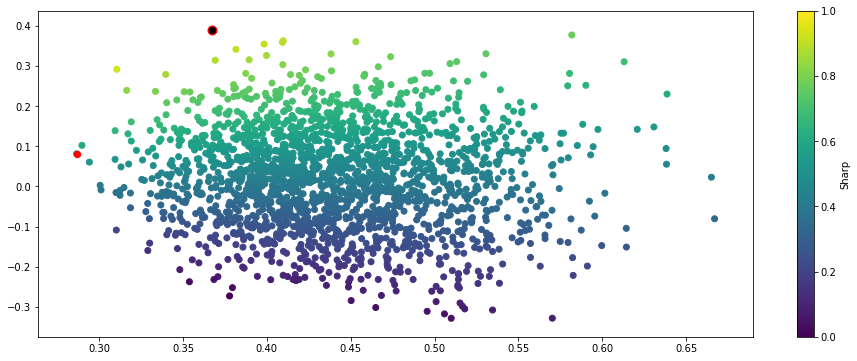

In [218]:
plt.figure(figsize=(16,6))
plt.scatter(all_vol, all_returns, c=all_sharp)
plt.scatter(all_vol[max_return], all_returns[max_return], c="r", s = 80)
plt.scatter(all_vol[max_Sharp], all_returns[max_Sharp], c="black", s = 40)
plt.scatter(all_vol[lowest_vol], all_returns[lowest_vol], c="r", s = 40)
plt.colorbar(label = "Sharp")